<b><h2>Variable Description</h2></b><br>
====================<br><br>

<b>date time year-month-day hour:minute:second</b><br>
<b>Appliances</b>, energy use in <b>Wh</b><br>
<b>lights</b>, energy use of light fixtures in the house in <b>Wh</b><br>
<b>T1</b>, Temperature in kitchen area, in <b>Celsius</b><br>
<b>RH_1</b>, Humidity in kitchen area, in <b>%</b><br>
<b>T2</b>, Temperature in living room area, in <b>Celsius</b><br>
<b>RH_2</b>, Humidity in living room area, in <b>%</b><br>
<b>T3</b>, Temperature in laundry room area, in<b>Celsius</b><br>
<b>RH_3</b>, Humidity in laundry room area, in <b>%</b><br>
<b>T4</b>, Temperature in office room, in <b>Celsius</b><br>
<b>RH_4</b>, Humidity in office room, in <b>%</b><br>
<b>T5</b>, Temperature in bathroom, in <b>Celsius</b><br>
<b>RH_5</b>, Humidity in bathroom, in <b>%</b><br>
<b>T6</b>, Temperature outside the building (north side), in <b>Celsius</b><br>
<b>RH_6</b>, Humidity outside the building (north side), in <b>%</b><br>
<b>T7</b>, Temperature in ironing room , in <b>Celsius</b><br>
<b>RH_7</b>, Humidity in ironing room, in <b>%</b><br>
<b>T8</b>, Temperature in teenager room 2, in <b>Celsius</b><br>
<b>RH_8</b>, Humidity in teenager room 2, in <b>%</b><br>
<b>T9</b>, Temperature in parents room, in <b>Celsius</b><br>
<b>RH_9</b>, Humidity in parents room, in <b>%</b><br>
<b>To</b>, Temperature outside (from Chièvres weather station), in <b>Celsius</b><br>
<b>Pressure</b> (from Chièvres weather station), in <b>mm Hg</b><br>
<b>RH_out</b>, Humidity outside (from Chièvres weather station), in <b>%</b><br>
<b>Windspeed</b> (from Chièvres weather station), in <b>m/s</b><br>
<b>Visibility</b> (from Chièvres weather station), in <b>km</b><br>
<b>Tdewpoint</b> (from Chièvres weather station), <b>Celcius</b><br>
<b>rv1</b>, Random variable 1, <b>nondimensional</b><br>
<b>rv2</b>, Rnadom variable 2, <b>nondimensional</b><br><br>

Where indicated, data from the nearest airport weather station (Chièvres Airport, Belgium) was downloaded from a public data set from 
Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4 months of data.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import ShuffleSplit
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from tpot import TPOTRegressor
import featuretools as ft
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

In [2]:
# Scaling function
def minmaxscaling(X):
    min_max=MinMaxScaler()
    X_minmax=pd.DataFrame(min_max.fit_transform(X),index =X.index,columns = X.columns)
    return X_minmax

In [3]:
df=pd.read_csv('Data/energydata_complete.csv',header=0)

<b><h2>Feature Engineering  </h2></b>

In [4]:
# column with null values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['hour']=df['date'].dt.hour.map("{:02}".format).astype('int64')

# Total Energy Consumption
df['Total'] = df['Appliances'] + df['lights']

# 0 is Sunday and 6 is Saturday
df['day_of_week']=df['date'].dt.strftime('%w').astype('int64')

In [6]:
df['month']=df['date'].dt.strftime('%m').astype('int64')

<b>Inference for month -</b> The data consist of 5 months from January to May

In [7]:
df['min']=df['date'].dt.minute.map("{:02}".format).astype('int64')

<b>Inference for min -</b> The data contains time in interval of 10 mins

In [8]:
df['period'] = df[['day_of_week','hour','min']].apply(lambda x:''.join(x.astype(str)),axis=1)
df['period'] = df['period'].apply(int)
df['time'] = df[['hour','min']].apply(lambda x:''.join(x.astype(str)),axis=1)
df['time'] = df['time'].apply(int)
df.set_index('date', inplace=True)
df_scaled = minmaxscaling(df);

<b><h2>Exploratory Data Analysis  </h2></b>

<b><h3><u>Energy Consumption Distribution</u> </h3></b>

In [9]:
labels = ['Appliances','lights']
values = [df['Appliances'].sum(),df['lights'].sum()]
trace = go.Pie(labels = labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

<b>Inference -</b> 
The <b>Appliances</b> have <b>highest</b> portion of Energy Consumption i.e <b>96.3%</b>

<b><h3><u>Monthwise Appliances Energy Consumption</u> :</h3></b>

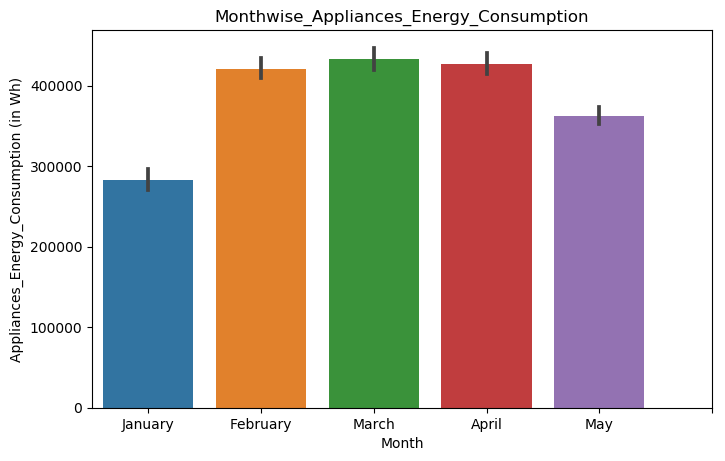

In [10]:
fig = plt.figure(figsize=(8,5), dpi = 100, facecolor = 'w', edgecolor = 'k')
ax = fig.add_subplot(111)
weeklyplot = sns.barplot(x="month",y="Appliances",data = df, estimator=sum)
weeklyplot.set_xticks([0,1,2,3,4,5])
weeklyplot.set_xticklabels(['January','February','March','April','May'])
plt.xlabel('Month')
plt.ylabel('Appliances_Energy_Consumption (in Wh)')
plt.title("Monthwise_Appliances_Energy_Consumption")
plt.savefig("Monthwise_Appliances_Energy_Consumption.png")
plt.show()

<b>Inference - </b><br> 
We cannot have good inference from the Monthly Distribution.<br> 
Since the Data for Month January is Incomplete

<b><h3><u>Daywise Appliances Energy Consumption</u> </h3></b>

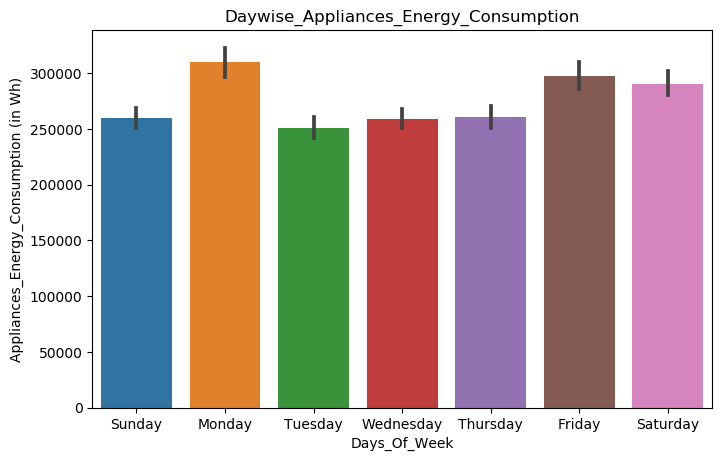

In [11]:
fig = plt.figure(figsize=(8,5), dpi = 100, facecolor = 'w', edgecolor = 'k')
ax = fig.add_subplot(111)
weeklyplot = sns.barplot(x="day_of_week",y="Appliances",data = df, estimator=sum)
weeklyplot.set_xticks([0,1,2,3,4,5,6])
weeklyplot.set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.xlabel('Days_Of_Week')
plt.ylabel('Appliances_Energy_Consumption (in Wh)')
plt.title("Daywise_Appliances_Energy_Consumption")
plt.savefig("Daywise_Appliances_Energy_Consumption.png")
plt.show()

<b>Inference - </b><br> 
The Appliances have -<br> 
<li><b>Highest</b> Energy Consumption on <b> Monday </b></li>
<li><b>Lowest</b> Energy Consumption on <b> Tuesday </b></li>

<b><h3><u>Hourwise Appliances Energy Consumption</u> </h3></b>

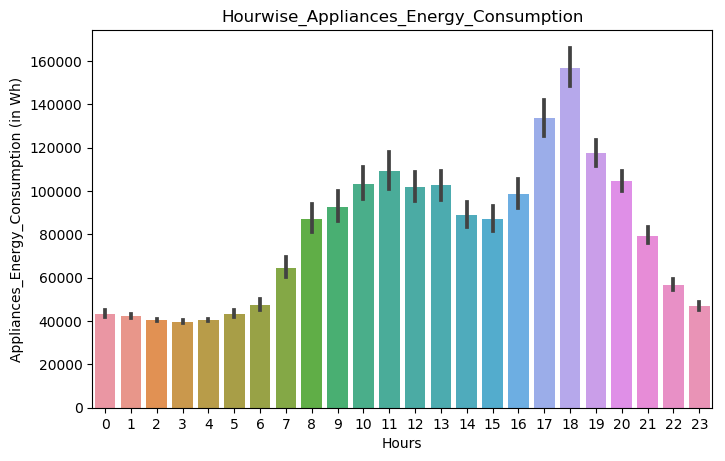

In [12]:
fig = plt.figure(figsize=(8,5), dpi = 100, facecolor = 'w', edgecolor = 'k')
ax = fig.add_subplot(111)
weeklyplot = sns.barplot(x="hour",y="Appliances",data = df, estimator=sum)
plt.xlabel('Hours')
plt.ylabel('Appliances_Energy_Consumption (in Wh)')
plt.title("Hourwise_Appliances_Energy_Consumption")
plt.savefig("Hourly_Appliances_Energy_Consumption.png")
plt.show()

<b>Inference - </b><br> 
The Appliances have -<br> 
<li><b>Highest</b> Energy Consumption at <b> 19 Hr </b></li>
<li><b>Lowest</b> Energy Consumption at <b> 3 Hr</b></li>

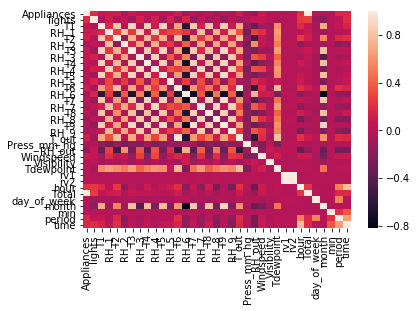

In [13]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

<b><h2>Regression Models </h2></b>

In [14]:
def Linear_Regression(feature_selection,X_train,y_train,X_test,y_test):

    lm = linear_model.LinearRegression()
    modellinear = lm.fit(X_train,y_train)
    y_train_predicted = modellinear.predict(X_train)
    y_test_predicted  = modellinear.predict(X_test)
    linear = calculation_metrics_regression(feature_selection,'LinearRegression',X_train,y_train,y_train_predicted,X_test,y_test,y_test_predicted)
    
    return linear

In [15]:
def Random_Forest_Regressor(feature_selection,X_train,y_train,X_test,y_test):
    param_grid={'n_estimators':[300], 
                'random_state':[42]
           } 
    rf = RandomForestRegressor()
    cv = LeaveOneLabelOut(X_train.shape)
    random = GridSearchCV(estimator=rf,cv=cv,param_grid=param_grid,n_jobs=-1)
    modelrandomforest = random.fit(X_train,y_train)
    y_train_predicted = modelrandomforest.predict(X_train)
    y_test_predicted  = modelrandomforest.predict(X_test)
    random_model = calculation_metrics_regression(feature_selection,'RandomForestRegressor',X_train,y_train,y_train_predicted,X_test,y_test,y_test_predicted)

    return random_model

In [16]:
def Neural_Network(feature_selection,X_train,y_train,X_test,y_test):
   
    nn = MLPRegressor(activation='identity',learning_rate='adaptive',alpha=0.55)
    modelneuralnetwork = nn.fit(X_train, y_train)
    y_train_predicted = modelneuralnetwork.predict(X_train)
    y_test_predicted  = modelneuralnetwork.predict(X_test)
    neural = calculation_metrics_regression(feature_selection,'NeuralNetwork',X_train,y_train,y_train_predicted,X_test,y_test,y_test_predicted)
    
    return neural

In [17]:
def Gradient_Booster(feature_selection,X_train,y_train,X_test,y_test):
    param_grid={'n_estimators':[300], 
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[5],
            'max_features':[1.0] 
           } 
    gb = GradientBoostingRegressor()
    cv = LeaveOneLabelOut(X_train.shape)
    gradient = GridSearchCV(estimator=gb,cv=cv,param_grid=param_grid,n_jobs=-1)
    modelgradientBooster = gradient.fit(X_train,y_train)
    modelbest_gradient = modelgradientBooster.best_estimator_
    y_train_predicted = modelbest_gradient.predict(X_train)
    y_test_predicted  = modelbest_gradient.predict(X_test)
    gradientBooster = calculation_metrics_regression(feature_selection,'GradientBooster',X_train,y_train,y_train_predicted,X_test,y_test,y_test_predicted)
    
    return gradientBooster

In [18]:
#Calculation
def rmse(correct,estimated):
    rmse_val = np.sqrt(mean_squared_error(correct,estimated)) 
    return rmse_val

def calculation_metrics_regression(feature_selection,model_name,X_train,y_train,y_train_predicted,X_test,y_test,y_test_predicted):
    
    r2_train = r2_score(y_train,y_train_predicted)
    r2_test  = r2_score(y_test,y_test_predicted)
    
    rms_train = rmse(y_train, y_train_predicted)
    rms_test  = rmse(y_test, y_test_predicted)
    
    mae_train = mean_absolute_error(y_train, y_train_predicted)
    mae_test  = mean_absolute_error(y_test, y_test_predicted)
    
    mape_train = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100
    mape_test  = np.mean(np.abs((y_test - y_test_predicted) / y_test)) * 100
    
    local_error = pd.DataFrame({'Feature_Selection':[feature_selection],
                                'Regression_Model':[model_name],
                                '_R2_train':[r2_train],
                                '_R2_test':[r2_test],
                                '_RMS_train':[rms_train],
                                '_RMS_test':[rms_test],
                                '_MAE_train':[mae_train],
                                '_MAE_test':[mae_test],
                                '_MAPE_train':[mape_train],
                                '_MAPE_test':[mape_test]                               
                               })
    
    calculated_error = pd.concat([local_error])
    
    return calculated_error

In [19]:
# All Regression Models
all_regression = pd.DataFrame({'Feature_Selection':[],
                                'Model':[],
                                '_R2_train':[],
                                '_R2_test':[],
                                '_RMS_train':[],
                                '_RMS_test':[],
                                '_MAE_train':[],
                                '_MAE_test':[],
                                '_MAPE_train':[],
                                '_MAPE_test':[]                               
                               })
n = 0
def allRegressionModel(feature_selection,X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    y_train = y_train.values
    y_test = y_test.values
    linear_regression= Linear_Regression(feature_selection,X_train,y_train.ravel(),X_test,y_test.ravel())
    random_forest_regressor= Random_Forest_Regressor(feature_selection,X_train,y_train.ravel(),X_test,y_test.ravel())
    neural_network= Neural_Network(feature_selection,X_train,y_train.ravel(),X_test,y_test.ravel()) 
    gradientbooster= Gradient_Booster(feature_selection,X_train,y_train.ravel(),X_test,y_test.ravel())
    global all_regression
    global n 
    if n==0:
        n = 1
        all_regression = pd.concat([linear_regression,random_forest_regressor,neural_network,gradientbooster])
    else:
        all_regression = pd.concat([all_regression,linear_regression,random_forest_regressor,neural_network,gradientbooster])
                                            
    return all_regression                                      

<b><h2>Feature Selection </h2></b>

In [20]:
X = df_scaled.drop(['Appliances','lights','rv1','rv2','Total','min'],axis=1)
y = df[['Appliances']]

In [21]:
# Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

<b><h3><u>Boruta</u> </h3></b>

In [22]:
X_boruta = X.values
y_boruta = y.values

In [23]:
rfc = RandomForestRegressor(n_jobs=-1,max_depth=6)
boruta_selector = BorutaPy(rfc,n_estimators='auto',verbose=2,random_state=1)

In [24]:
boruta_selector.fit(X_boruta,y_boruta.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	10
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	2


BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=122, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x1c1fb00090>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x1c1fb00090>,
     two_step=True, verbose=2)

In [25]:
feat_imp = pd.Series(boruta_selector.ranking_,X.columns).sort_values(ascending=True)
feat_imp  = feat_imp.nsmallest(18)
feat_imp = feat_imp.to_frame().reset_index()
feat_imp = feat_imp.rename(columns= {'index':'Features',0:'Ranking'})

<font size=3><u><i>Features Ranking from Boruta</i></u> </font>

In [26]:
feat_imp

,Features,Ranking
0,T8,1
1,month,1
2,day_of_week,1
3,hour,1
4,Tdewpoint,1
5,Press_mm_hg,1
6,T_out,1
7,RH_9,1
8,T9,1
9,RH_8,1


In [27]:
X_boruta_after = X[feat_imp['Features']]

In [28]:
allRegressionModel('Boruta',X_boruta_after, y)

,Feature_Selection,Regression_Model,_MAE_test,_MAE_train,_MAPE_test,_MAPE_train,_R2_test,_R2_train,_RMS_test,_RMS_train
0,Boruta,LinearRegression,55.370687,56.000433,67.237007,65.567098,0.081968,0.082850,95.496586,99.075966
0,Boruta,RandomForestRegressor,31.443960,11.789613,31.454150,11.670347,0.576063,0.942313,64.894779,24.847768
0,Boruta,NeuralNetwork,55.614885,56.230962,68.005521,66.421618,0.067264,0.071559,96.258363,99.683965
0,Boruta,GradientBooster,35.795611,23.793484,38.163028,26.813032,0.524402,0.822221,68.735174,43.620336


<b><h3><u>Tsfresh</u> </h3></b>

In [29]:
X_tsfresh = X
X_tsfresh = X_tsfresh.reset_index()
y_tsfresh = y.values

In [30]:
# For Extracting Minimal Features
extracted_features = extract_features(X_tsfresh, column_id="date", column_sort="period",show_warnings=False, default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


In [31]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y_tsfresh.ravel())

In [32]:
allRegressionModel('Tsfresh',features_filtered, y)

,Feature_Selection,Regression_Model,_MAE_test,_MAE_train,_MAPE_test,_MAPE_train,_R2_test,_R2_train,_RMS_test,_RMS_train
0,Boruta,LinearRegression,55.370687,56.000433,67.237007,65.567098,0.081968,0.082850,95.496586,99.075966
0,Boruta,RandomForestRegressor,31.443960,11.789613,31.454150,11.670347,0.576063,0.942313,64.894779,24.847768
0,Boruta,NeuralNetwork,55.614885,56.230962,68.005521,66.421618,0.067264,0.071559,96.258363,99.683965
0,Boruta,GradientBooster,35.795611,23.793484,38.163028,26.813032,0.524402,0.822221,68.735174,43.620336
0,Tsfresh,LinearRegression,53.495412,53.806220,64.844472,62.966507,0.142214,0.154840,92.309956,95.108146
0,Tsfresh,RandomForestRegressor,30.476280,11.553670,30.070338,11.272543,0.583953,0.943016,64.288042,24.695799
0,Tsfresh,NeuralNetwork,52.120028,52.312204,60.837947,58.618613,0.114560,0.120250,93.786124,97.034867
0,Tsfresh,GradientBooster,34.396331,23.082602,36.381054,26.203277,0.530236,0.828442,68.312281,42.850230


<b><h3><u>Featuretools</u> </h3></b>

In [33]:
X_featuretools = X
y_featuretools = y
X_featuretools = X_featuretools.reset_index()
y_featuretools = y_featuretools.reset_index()
entities = {"appliances":(y_featuretools,"date"),
           "rest":(X_featuretools,"date")}
relationships = [("appliances","date","rest","date")]
feature_matrix_app,features_defs = ft.dfs(entities=entities,relationships=relationships,target_entity="appliances")
X_featuret = feature_matrix_app.drop(['Appliances'],axis=1)
y_featuret = feature_matrix_app[['Appliances']]
y_featuret1 = y_featuret.values

In [34]:
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_featuret,y_featuret1.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
importances = clf.feature_importances_
featools_imp = pd.Series(importances,X_featuret.columns).sort_values(ascending=False)
featools_imp  = featools_imp.nlargest(20)
featools_imp = featools_imp.to_frame().reset_index()
featools_imp = featools_imp.rename(columns= {'index':'Features',0:'Importance'})

In [36]:
featools_imp

,Features,Importance
0,MEAN(rest.hour),0.039159
1,MIN(rest.hour),0.038011
2,MAX(rest.hour),0.033902
3,SUM(rest.hour),0.033670
4,MEAN(rest.T3),0.014248
5,MAX(rest.Press_mm_hg),0.013226
6,MIN(rest.T3),0.012733
7,MAX(rest.T3),0.012655
8,SUM(rest.T3),0.012509
9,SUM(rest.Press_mm_hg),0.012372


In [37]:
X_featuret = X_featuret[featools_imp['Features']]

In [38]:
allRegressionModel('FeatureTools',X_featuret, y)

,Feature_Selection,Regression_Model,_MAE_test,_MAE_train,_MAPE_test,_MAPE_train,_R2_test,_R2_train,_RMS_test,_RMS_train
0,Boruta,LinearRegression,55.370687,56.000433,67.237007,65.567098,0.081968,0.082850,95.496586,99.075966
0,Boruta,RandomForestRegressor,31.443960,11.789613,31.454150,11.670347,0.576063,0.942313,64.894779,24.847768
0,Boruta,NeuralNetwork,55.614885,56.230962,68.005521,66.421618,0.067264,0.071559,96.258363,99.683965
0,Boruta,GradientBooster,35.795611,23.793484,38.163028,26.813032,0.524402,0.822221,68.735174,43.620336
0,Tsfresh,LinearRegression,53.495412,53.806220,64.844472,62.966507,0.142214,0.154840,92.309956,95.108146
0,Tsfresh,RandomForestRegressor,30.476280,11.553670,30.070338,11.272543,0.583953,0.943016,64.288042,24.695799
0,Tsfresh,NeuralNetwork,52.120028,52.312204,60.837947,58.618613,0.114560,0.120250,93.786124,97.034867
0,Tsfresh,GradientBooster,34.396331,23.082602,36.381054,26.203277,0.530236,0.828442,68.312281,42.850230
0,FeatureTools,LinearRegression,55.596762,56.310106,67.297477,66.155741,0.055072,0.059054,96.885420,100.353066
0,FeatureTools,RandomForestRegressor,33.134333,12.640963,32.815217,12.417212,0.518035,0.934527,69.193709,26.471592


<b><h3><u>Recursive Feature Elimination</u> </h3></b>

In [39]:
y_rfe = y.values
svm = LinearSVC()
rfe = RFE(svm,8)
rfe = rfe.fit(X,y_rfe.ravel())
rfe_imp = rfe.ranking_
rfe_imp = pd.Series(rfe_imp,X.columns).sort_values(ascending=False)
rfe_imp  = rfe_imp.nsmallest(15)
rfe_imp = rfe_imp.to_frame().reset_index()

In [40]:
rfe_imp

,index,0
0,RH_8,1
1,T9,1
2,RH_4,1
3,RH_3,1
4,T3,1
5,RH_2,1
6,RH_1,1
7,T8,1
8,RH_9,2
9,T2,3


In [41]:
X_rfe = X[rfe_imp['index']]
models_list = allRegressionModel('RFE',X_rfe,y)
models_list = models_list.reset_index()
models_list = models_list.drop(['index'],axis=1)

In [42]:
models_list

,Feature_Selection,Regression_Model,_MAE_test,_MAE_train,_MAPE_test,_MAPE_train,_R2_test,_R2_train,_RMS_test,_RMS_train
0,Boruta,LinearRegression,55.370687,56.000433,67.237007,65.567098,0.081968,0.082850,95.496586,99.075966
1,Boruta,RandomForestRegressor,31.443960,11.789613,31.454150,11.670347,0.576063,0.942313,64.894779,24.847768
2,Boruta,NeuralNetwork,55.614885,56.230962,68.005521,66.421618,0.067264,0.071559,96.258363,99.683965
3,Boruta,GradientBooster,35.795611,23.793484,38.163028,26.813032,0.524402,0.822221,68.735174,43.620336
4,Tsfresh,LinearRegression,53.495412,53.806220,64.844472,62.966507,0.142214,0.154840,92.309956,95.108146
5,Tsfresh,RandomForestRegressor,30.476280,11.553670,30.070338,11.272543,0.583953,0.943016,64.288042,24.695799
6,Tsfresh,NeuralNetwork,52.120028,52.312204,60.837947,58.618613,0.114560,0.120250,93.786124,97.034867
7,Tsfresh,GradientBooster,34.396331,23.082602,36.381054,26.203277,0.530236,0.828442,68.312281,42.850230
8,FeatureTools,LinearRegression,55.596762,56.310106,67.297477,66.155741,0.055072,0.059054,96.885420,100.353066
9,FeatureTools,RandomForestRegressor,33.134333,12.640963,32.815217,12.417212,0.518035,0.934527,69.193709,26.471592


# Model Validation 

In [43]:
# cross validation
def cross_validation_function(model,X,y):
    cv = ShuffleSplit(n_splits= 10, test_size = 0.25,random_state=42)
    scores = cross_val_score(model,X,y,cv=cv, scoring ='r2')
    score = scores.mean()
    deviation = scores.std()*2
    return score,deviation

In [44]:
y1 = y.values

In [45]:
#RandomForestRegressor
score,deviation = cross_validation_function(RandomForestRegressor(n_estimators =300, random_state = 42),features_filtered, y1.ravel())
print("R2_Score: %0.2f (+/- %0.2f)" % (score,deviation))

R2_Score: 0.57 (+/- 0.03)


<b>Random Forest Regressor</b> is selected as <b>best</b> model for prediction with <br><i>R2_test_score</i> <b>0.57</b> <br>
<i>R2_train score</i> <b>0.94</b>

<b><h3><u>Tpot</u> </h3></b><br>
Automated Machine Learning for Supervised Regression task

In [46]:
y_tpot = y_train.values

In [47]:
pipeline_optimizer  = TPOTRegressor(generations=10, population_size=20, cv = 3,
                                    random_state=42, verbosity=2,scoring = 'r2')

In [48]:
pipeline_optimizer.fit(X_train,y_tpot.ravel())

Optimization Progress:  18%|█▊        | 40/220 [05:39<15:55,  5.31s/pipeline]  

Generation 1 - Current best internal CV score: 0.5002288153482359


Optimization Progress:  28%|██▊       | 61/220 [14:46<46:44, 17.64s/pipeline]  

Generation 2 - Current best internal CV score: 0.5002288153482359


Optimization Progress:  37%|███▋      | 81/220 [21:21<25:35, 11.05s/pipeline]  

Generation 3 - Current best internal CV score: 0.5002288153482359


Optimization Progress:  46%|████▌     | 101/220 [27:27<43:04, 21.72s/pipeline]

Generation 4 - Current best internal CV score: 0.5002288153482359


Optimization Progress:  55%|█████▌    | 122/220 [39:27<2:10:52, 80.13s/pipeline] 

Generation 5 - Current best internal CV score: 0.5042190386275885


Optimization Progress:  65%|██████▌   | 143/220 [52:19<1:06:28, 51.80s/pipeline] 

Generation 6 - Current best internal CV score: 0.5042190386275885


Optimization Progress:  74%|███████▍  | 163/220 [1:00:55<20:52, 21.98s/pipeline]

Generation 7 - Current best internal CV score: 0.5042190386275885


Optimization Progress:  83%|████████▎ | 183/220 [1:08:34<16:19, 26.47s/pipeline]

Generation 8 - Current best internal CV score: 0.5042190386275885


Optimization Progress:  92%|█████████▏| 203/220 [1:13:09<03:41, 13.05s/pipeline]

Generation 9 - Current best internal CV score: 0.5042190386275885


Generation 10 - Current best internal CV score: 0.5045885784276378

Best pipeline: ElasticNetCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.25, min_samples_leaf=1, min_samples_split=4, n_estimators=100), l1_ratio=0.7000000000000001, tol=1e-05)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraTreesRegressor': {'n_estimato....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
       crossover_rate=0.1, cv=3, disable_update_check=False,
       early_stop=None, generations=10, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=20, periodic_checkpoint_folder=None,
       population_size=20, random_state=42, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [50]:
print(pipeline_optimizer.score(X_test, y_test))

0.5893369019106798


In [51]:
pipeline_optimizer.export('AutomatedMLEnnergyConsumptionPipelineTpot.py ')

True